In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tqdm import tqdm
from skimage.transform import resize

from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

2024-02-06 16:26:20.361185: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 16:26:20.361289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 16:26:20.488468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [3]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'


X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=150

for label in labels:
    path = os.path.join(train_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        img_array = plt.imread(os.path.join(path, img))
        img_resized = resize(img_array, (image_size, image_size, 3))
        X_train.append(img_resized)
        Y_train.append(class_num)

for label in labels:
    path = os.path.join(test_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        img_array = plt.imread(os.path.join(path, img))
        img_resized = resize(img_array, (image_size, image_size, 3))
        X_train.append(img_resized)
        Y_train.append(class_num)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [4]:
X_train.shape #No of sample = 7023

(7023, 150, 150, 3)

In [5]:
# Shuffling data
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

In [6]:
#After shuffling sample size remains same
X_train.shape

(7023, 150, 150, 3)

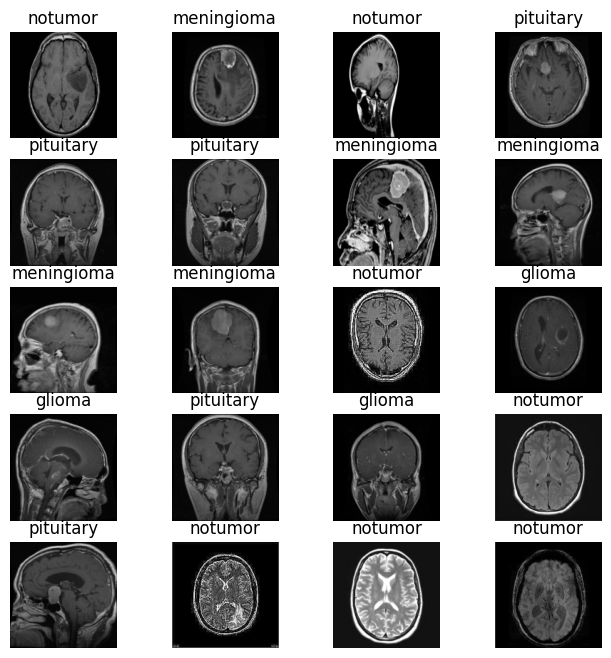

In [7]:
#plotting the images
plt.figure(figsize=(8,8))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(X_train[i])
    plt.title(labels[Y_train[i]])
    plt.axis("off")
plt.show()

In [8]:
# Split the data into training and testing and validation
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [9]:
# convert string to categorical
from keras.utils import to_categorical
y_train_new = []
y_valid_new = []
y_test_new = []

for i in range(len(Y_train)):
    y_train_new.append(to_categorical(Y_train[i], num_classes=4))

for i in range(len(Y_valid)):
    y_valid_new.append(to_categorical(Y_valid[i], num_classes=4))

for i in range(len(Y_test)):
    y_test_new.append(to_categorical(Y_test[i], num_classes=4))

y_train_new = np.array(y_train_new)
y_valid_new = np.array(y_valid_new)
y_test_new = np.array(y_test_new)


In [10]:
from keras.applications import mobilenet_v2
# Load MobileNetV2 model with pre-trained weights
base_model = mobilenet_v2.MobileNetV2(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Add custom classifier layers on top of MobileNetV2 base
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(len(labels), activation='softmax')(x)



9406464/9406464 [==============================] - 0s 0us/step


In [11]:
# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']        

In [12]:
history = model.fit(X_train, y_train_new, batch_size=64, epochs=10, validation_data=(X_valid, y_valid_new))

Epoch 1/10


I0000 00:00:1707236951.137806      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 [==============================] - 11s 71ms/step - loss: 0.5861 - accuracy: 0.7909 - val_loss: 0.3358 - val_accuracy: 0.8719
Epoch 2/10
79/79 [==============================] - 3s 42ms/step - loss: 0.2363 - accuracy: 0.9114 - val_loss: 0.2207 - val_accuracy: 0.9217
Epoch 3/10
79/79 [==============================] - 3s 43ms/step - loss: 0.1775 - accuracy: 0.9361 - val_loss: 0.2094 - val_accuracy: 0.9235
Epoch 4/10
79/79 [==============================] - 3s 43ms/step - loss: 0.1364 - accuracy: 0.9509 - val_loss: 0.1887 - val_accuracy: 0.9306
Epoch 5/10
79/79 [==============================] - 3s 43ms/step - loss: 0.0979 - accuracy: 0.9680 - val_loss: 0.1653 - val_accuracy: 0.9377
Epoch 6/10
79/79 [==============================] - 3s 43ms/step - loss: 0.0821 - accuracy: 0.9735 - val_loss: 0.1704 - val_accuracy: 0.9431
Epoch 7/10
79/79 [==============================] - 3s 43ms/step - loss: 0.0568 - accuracy: 0.9842 - val_loss: 0.1131 - val_accuracy: 0.9698
Epoch 8/10
79/79 [=====

44/44 [==============================] - 3s 43ms/step - loss: 0.1377 - accuracy: 0.9544


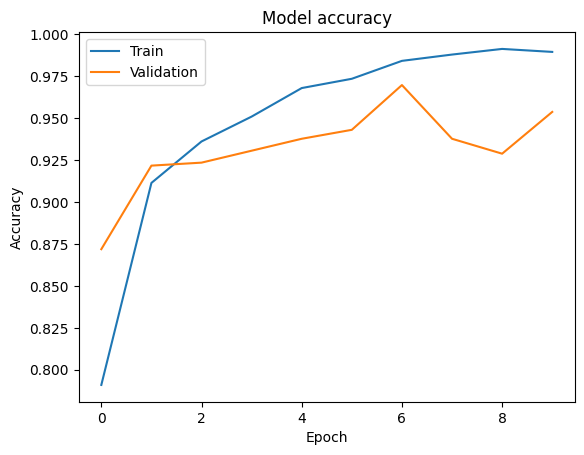

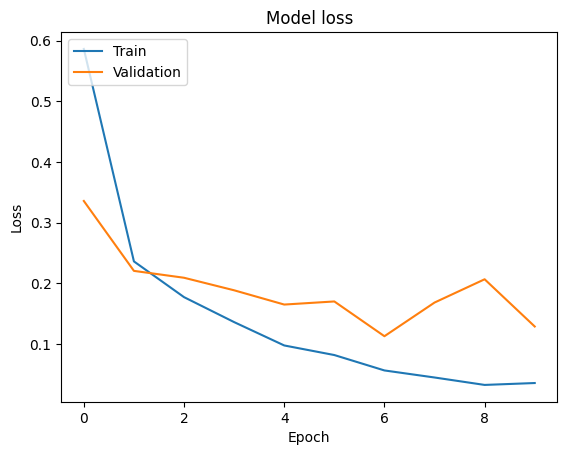

In [13]:
# Evaluate the model
model.evaluate(X_test, y_test_new)

# Plot the accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
# Save the model
model.save('brain_tumor.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 2s 21ms/step


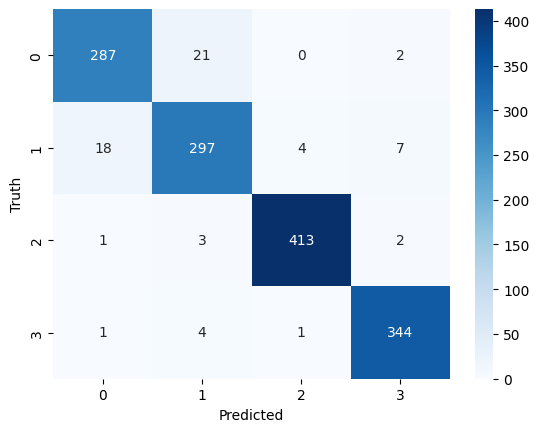

In [15]:
# Load the model
from keras.models import load_model
model = load_model('brain_tumor.h5')

# Predict the model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [16]:
# Classification report
from sklearn.metrics import classification_report

print(classification_report(Y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

      glioma       0.93      0.93      0.93       310
  meningioma       0.91      0.91      0.91       326
     notumor       0.99      0.99      0.99       419
   pituitary       0.97      0.98      0.98       350

    accuracy                           0.95      1405
   macro avg       0.95      0.95      0.95      1405
weighted avg       0.95      0.95      0.95      1405



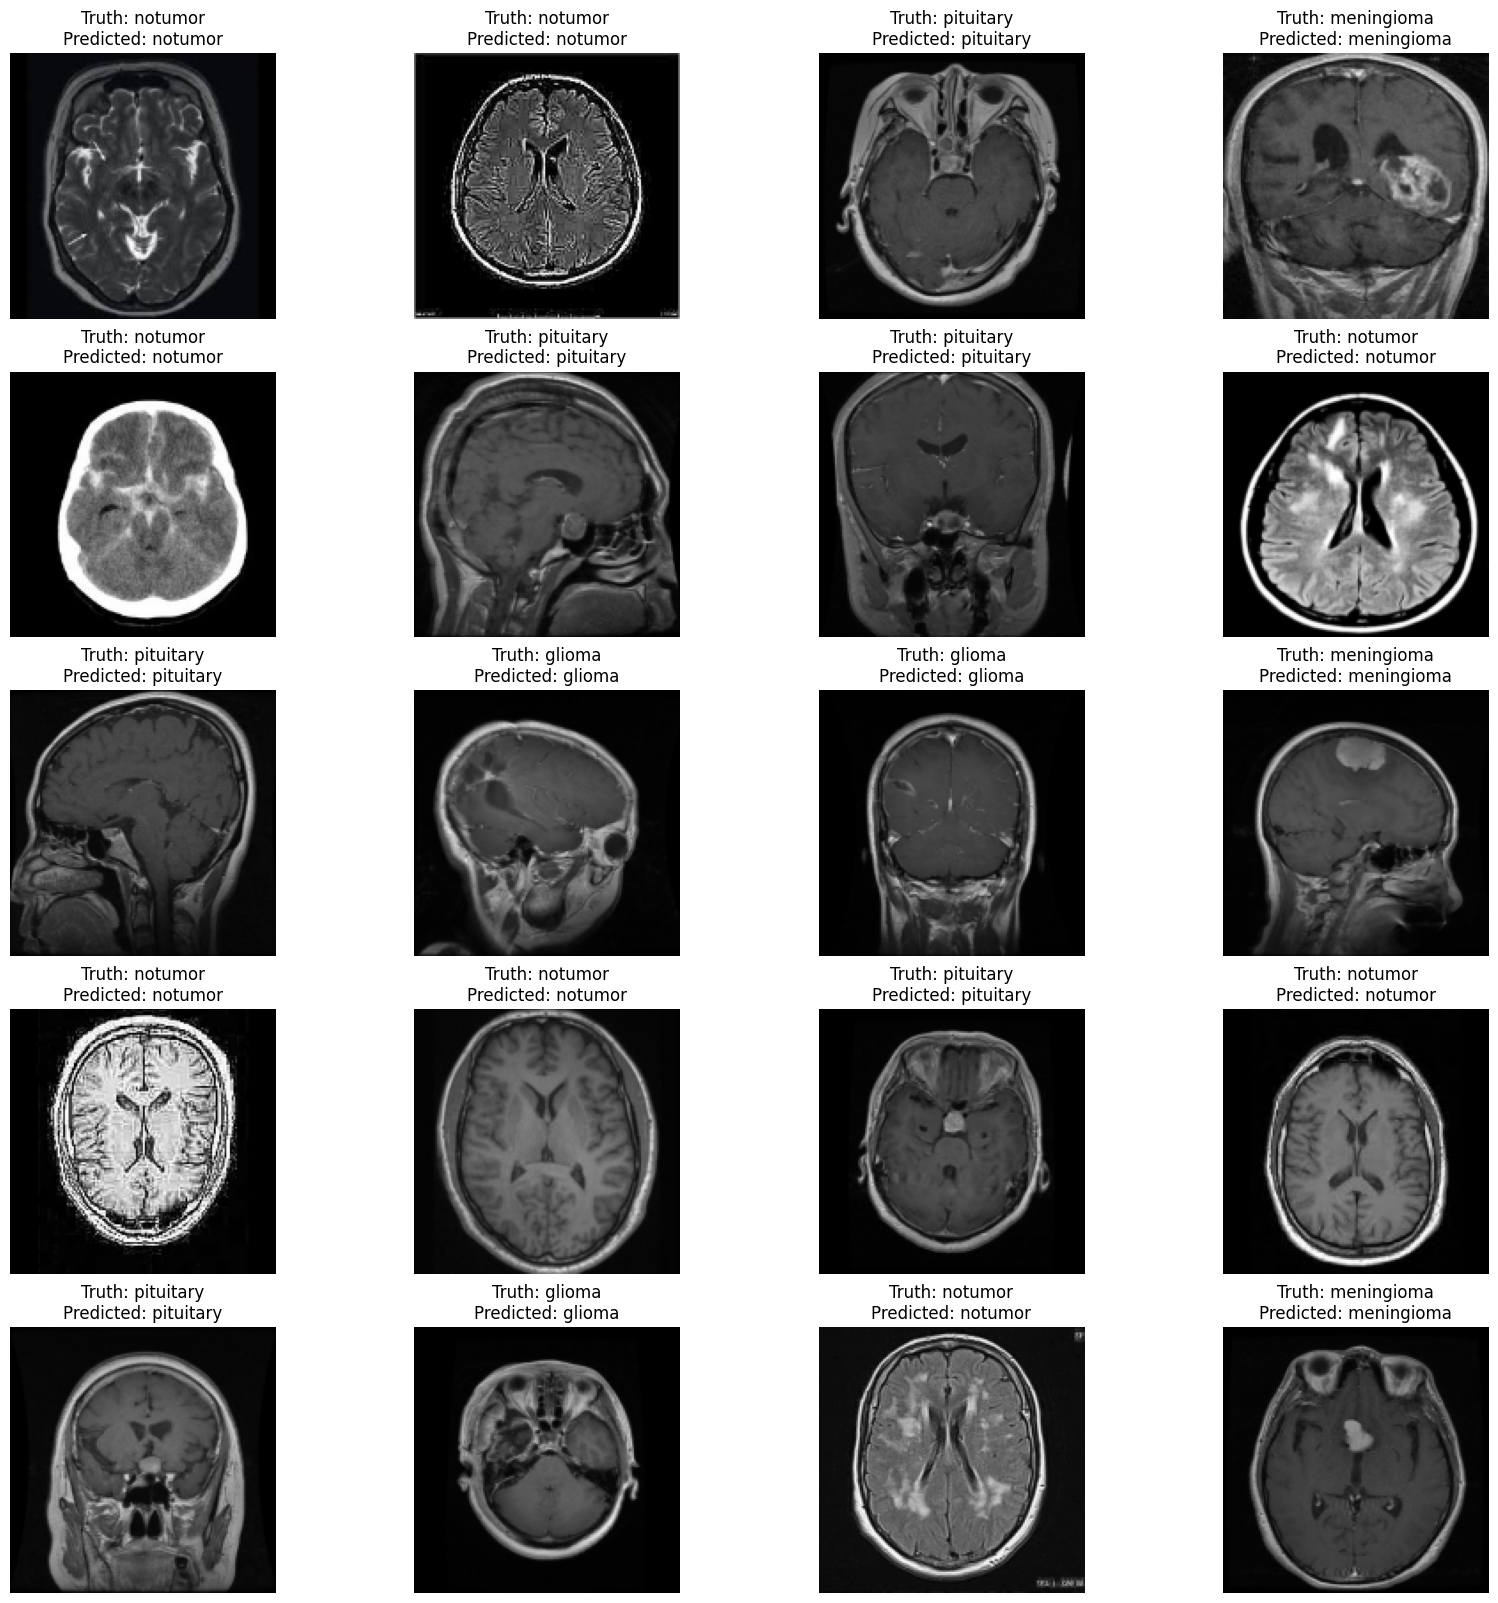

In [17]:
# Visualizing Model Predictions
plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(X_test[i])
    plt.title(f"Truth: {labels[Y_test[i]]}\nPredicted: {labels[y_pred[i]]}")
    plt.axis('off')
plt.show()